<a href="https://colab.research.google.com/github/NGeorggin/COMPSCI175FinalProject/blob/main/CS175DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rlcard
import os
import argparse
import rlcard
from rlcard.agents import (
    CFRAgent,
    RandomAgent,
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  2.035
----------------------------------------
INFO - Step 100, rl-loss: 389.4891052246094
INFO - Copied model parameters to target network.
INFO - Step 169, rl-loss: 1262.0145263671875
----------------------------------------
  episode      |  100
  reward       |  3.5645
----------------------------------------
INFO - Step 332, rl-loss: 316.91400146484375
----------------------------------------
  episode      |  200
  reward       |  1.901
----------------------------------------
INFO - Step 507, rl-loss: 1893.730712890625
----------------------------------------
  episode      |  300
  reward       |  1.6405
----------------------------------------
INFO - Step 657, rl-loss: 1552.3599853515625
----------------------------------------
  episode      |  400
  reward       |  2.9295
----------------------------------------
INFO - Step 832, rl-loss: 958.7032470703125
------------------

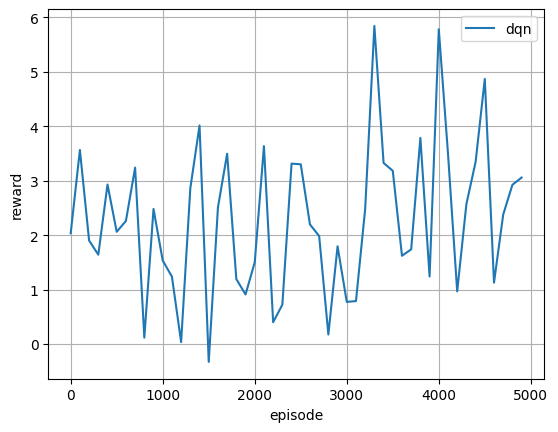

In [48]:
import os
import argparse

import torch

import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
)

def train(args):

    # Check whether gpu is available
    device = get_device()

    # Seed numpy, torch, random
    set_seed(args.seed)

    # Make the environment with seed
    env = rlcard.make(
        args.env,
        config={
            'seed': args.seed,
        }
    )

    # Initialize the agent and use random agents as opponents
    from rlcard.agents import DQNAgent
    agent = DQNAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        mlp_layers=[64,64],
        device=device,
    )

    agents = [agent]
    for _ in range(1, env.num_players):
        agents.append(RandomAgent(num_actions=env.num_actions))
    env.set_agents(agents)

    # Start training
    with Logger(args.log_dir) as logger:
        for episode in range(args.num_episodes):

            # Generate data from the environment
            trajectories, payoffs = env.run(is_training=True)

            # Reorganaize the data to be state, action, reward, next_state, done
            trajectories = reorganize(trajectories, payoffs)

            # Feed transitions into agent memory, and train the agent
            # Here, we assume that DQN always plays the first position
            # and the other players play randomly (if any)
            for ts in trajectories[0]:
                agent.feed(ts)

            # Evaluate the performance. Play with random agents.
            if episode % args.evaluate_every == 0:
                logger.log_performance(
                    episode,
                    tournament(
                        env,
                        args.num_eval_games,
                    )[0]
                )

        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path

    # Plot the learning curve
    plot_curve(csv_path, fig_path, args.algorithm)

    # Save model
    save_path = os.path.join(args.log_dir, 'model.pth')
    torch.save(agent, save_path)
    print('Model saved in', save_path)

In [45]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser("DQN example in RLCard")
    parser.add_argument(
        '--env',
        type=str,
        default='no-limit-holdem',
        choices=[
            'blackjack',
            'leduc-holdem',
            'limit-holdem',
            'doudizhu',
            'mahjong',
            'no-limit-holdem',
            'uno',
            'gin-rummy',
            'bridge',
        ],
    )
    parser.add_argument(
        '--algorithm',
        type=str,
        default='dqn',
        choices=[
            'dqn',
            'nfsp',
        ],
    )
    parser.add_argument(
        '--cuda',
        type=str,
        default='',
    )
    parser.add_argument(
        '--seed',
        type=int,
        default=42,
    )
    parser.add_argument(
        '--num_episodes',
        type=int,
        default=5000,
    )
    parser.add_argument(
        '--num_eval_games',
        type=int,
        default=2000,
    )
    parser.add_argument(
        '--evaluate_every',
        type=int,
        default=100,
    )
    parser.add_argument(
        '--log_dir',
        type=str,
        default='experiments/leduc_holdem_dqn_result/',
    )

    args, unknown = parser.parse_known_args()

    os.environ["CUDA_VISIBLE_DEVICES"] = args.cuda
    train(args)

{'seed': 42, 'num_episodes': 5000, 'num_eval_games': 2000, 'evaluate_every': 100, 'log_dir': 'experiments/no_limit_holdem_cfr_result/'}

Logs saved in experiments/no_limit_holdem_cfr_result/


KeyboardInterrupt: 